In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import os

from background_models import bg_dampe
from constants import dampe_excess_bin_high, dampe_bins, fermi_psf
from constants import rho_earth
from finite_clump_vectorized import rho_s_dampe, luminosity, dphi_de_g
from finite_clump_vectorized import gamma_ray_extent, line_width_constraint

from nfw_clump import NFW_params
from tt_clump import TT_params


colors = [c["color"] for c in plt.rcParams['axes.prop_cycle']]
# Photon energy at which to compute fluxes
e_gamma_ref = 10.
# Significance used for line width constraint
n_sigma = 3.
# Directory with Ben's probability data files
pr_base_path = "../DAMPE+DM clumps/data/likelihoods/"

def log_levels(data, n=10):
    return np.logspace(np.log10(np.nanmin(data)), np.log10(np.nanmax(data)), n)


def normal_contours(dist, r_s, val, ax, levels=None):
    """Creates density contour plot with labels.
    """
    if levels is None:
        levels = log_levels(val)
        
    cs = ax.contour(dist, r_s, val, levels=levels, norm=LogNorm())
    ax.clabel(cs, inline=True)


def sci_contours(dist, r_s, val, ax, levels=None):
    """Creates density contour plot with labels using scientific notation.
    """
    if levels is None:
        levels = log_levels(val)

    cs = ax.contour(dist, r_s, val, levels=levels, norm=LogNorm())
    clabels = {level: (r"%.2f" % (level / 10.**np.floor(np.log10(level)))) +
               (r"$\times 10^{%i}$" % np.floor(np.log10(level)))
               for level in cs.levels}
    ax.clabel(cs, inline=True, fmt=clabels)


def log_contours(dist, r_s, val, ax, levels=None):
    """Creates density contour plot with contour labels at powers of 10.
    """
    if levels is None:
        levels = log_levels(val)

    cs = ax.contour(dist, r_s, val, levels=levels, norm=LogNorm())
    clabels = {l: r"$10^{%i}$" % np.log10(l) for l in cs.levels}
    ax.clabel(cs, inline=True, fmt=clabels)

# NFW profile

In [2]:
gamma_nfw = 0.5

dist = np.logspace(-3, np.log10(3), 20)
r_s = np.logspace(-2, 2, 20)
dist_mg, r_s_mg = np.meshgrid(dist, r_s)

base_path_nfw = 'data/nfw_gamma_%.1f_v4/' % gamma_nfw

## Load results

In [3]:
for var in ["dist", "r_s"]:
    exec(var + " = np.loadtxt('" + base_path_nfw + var + ".csv')")

for var in ["rhos", "rho_rel", "lum", "dphi_de_g", "extent"]:
    exec(var + "_nfw = np.loadtxt('" + base_path_nfw + var + ".csv')")


# Load likelihoods using Ben's processing
dist_pr, r_s_pr, pr_nfw = np.loadtxt(
    pr_base_path + "nfw_v2/nfw_gamma_0.5.csv",
    delimiter=',').T

dist_pr = dist_pr.reshape(len(np.unique(dist_pr)), -1)
r_s_pr = r_s_pr.reshape(dist_pr.shape)
pr_nfw = pr_nfw.reshape(dist_pr.shape)

## $\rho_s$, $\frac{\rho_s + \rho_\oplus}{\rho_\oplus}$

In [5]:
rhos_nfw = rho_s_dampe(dist_mg, r_s_mg, gamma_nfw, "nfw")

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in 

In [16]:
rho_rel_nfw = (rhos_nfw + rho_earth) / rho_earth

## $\mathcal{L}$

In [6]:
lum_nfw = luminosity(r_s_mg, rhos_nfw, gamma_nfw, "nfw")

## $\frac{d\phi_\gamma}{d E_\gamma} (E_\gamma = 10$ GeV)

In [7]:
dphi_de_g_nfw = dphi_de_g(e_gamma_ref, dist_mg, r_s_mg, rhos_nfw,
                          gamma_nfw, "nfw", fermi_psf)

## $\frac{\theta_{50\%}}{\theta_{\mathrm{Fermi}}}$

In [ ]:
extent_nfw = gamma_ray_extent(dist_mg, r_s_mg, rhos_nfw, gamma_nfw, "nfw", e_gamma_ref)

## Line width constraint

In [4]:
lw_nfw = line_width_constraint(dist_mg, r_s_mg, rhos_nfw, gamma_nfw, "nfw", n_sigma)

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning)
/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning

## Save results

In [12]:
for var in ["dist", "r_s"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var))

for var in ["rhos", "rho_rel", "lum", "dphi_de_g", "extent"]:
    np.savetxt(base_path_nfw + var + ".csv", eval(var + "_nfw"))

## Plot everything together

/Users/acoogan/.pyenv/versions/2.7.13/lib/python2.7/site-packages/matplotlib/contour.py:1544: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


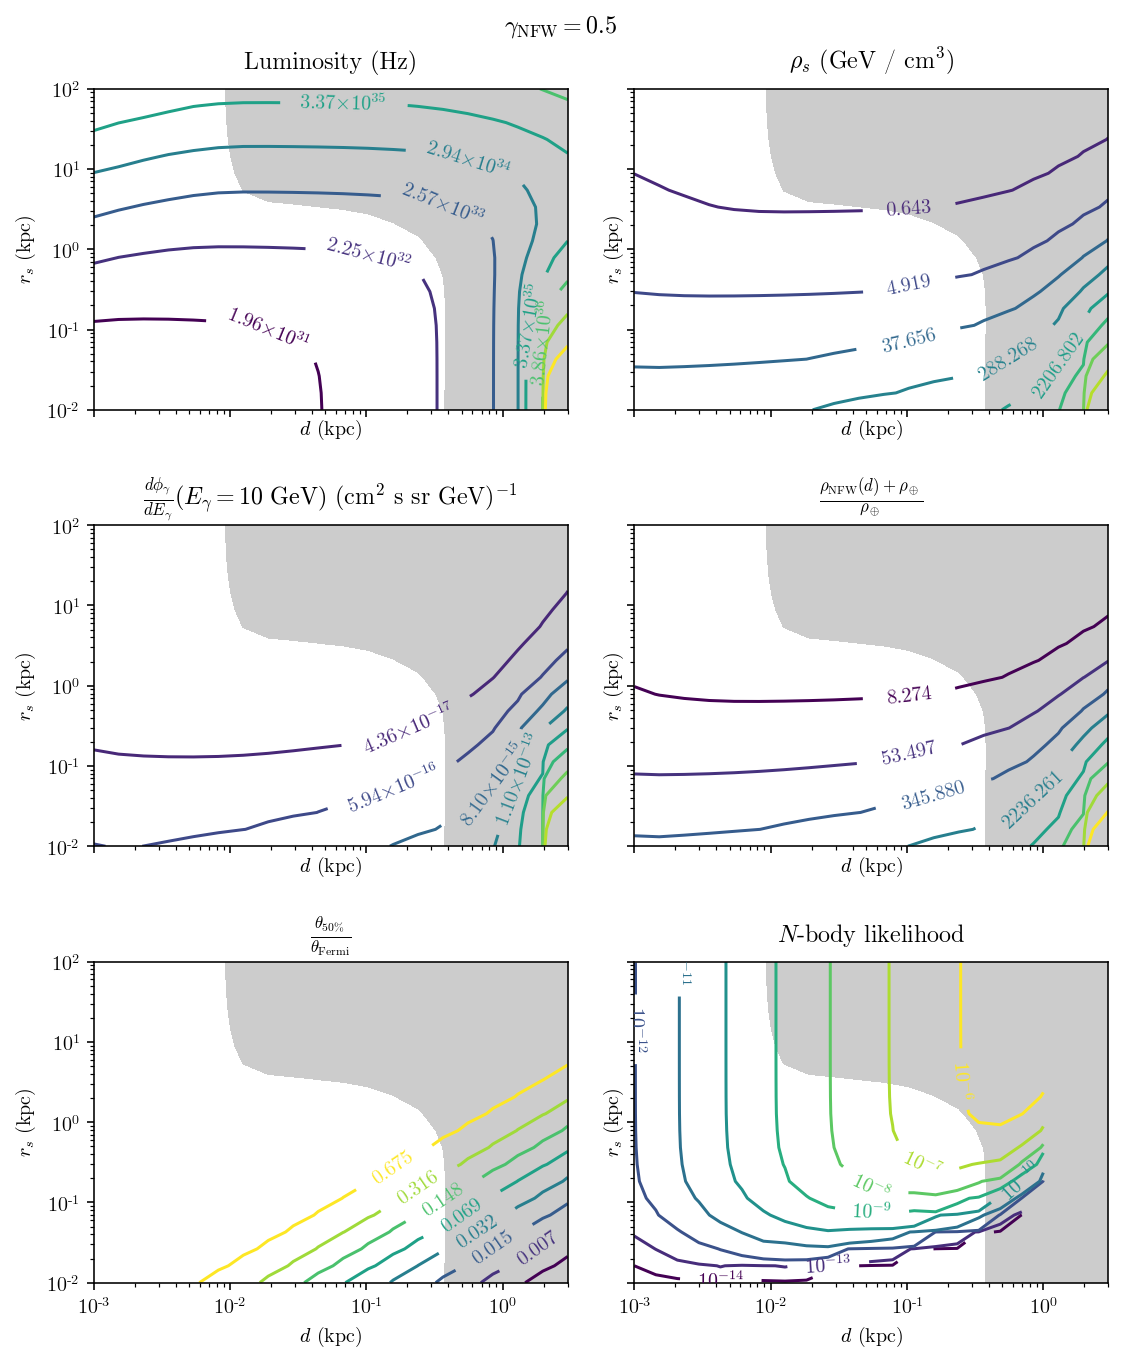

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True,
                        figsize=(8, 10))

fig.suptitle(r"$\gamma_{\mathrm{NFW}} = %.1f$" % gamma_nfw)

for ax in axs.flatten():
    ax.set_xlabel(r"$d$ (kpc)")
    ax.set_ylabel(r"$r_s$ (kpc)")
    # Line width constraint
    ax.contourf(dist, r_s, lw_nfw, levels=[n_sigma, np.max(lw_nfw)],
                colors='k', alpha=0.2)

ax = axs[0, 0]
# Must be done before plotting to get label formatting right.
# Only need to do this for one subplot.
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(dist[[0, -1]])
ax.set_ylim(r_s[[0, -1]])
ax.set_title("Luminosity (Hz)", pad=10)
sci_contours(dist, r_s, lum_nfw, ax)

ax = axs[0, 1]
ax.set_title(r"$\rho_s$ (GeV / cm$^3$)", pad=10)
normal_contours(dist, r_s, rhos_nfw, ax)

ax = axs[1, 0]
ax.set_title(r"$\frac{d\phi_\gamma}{d E_\gamma}(E_\gamma=10\ "
             r"\mathrm{GeV})$ (cm$^2$ s sr GeV)$^{-1}$", pad=10)
sci_contours(dist, r_s, dphi_de_g_nfw, ax)

ax = axs[1, 1]
ax.set_title(r"$\frac{\rho_{\mathrm{NFW}}(d) +"
             r"\rho_\oplus}{\rho_\oplus}$", pad=10)
normal_contours(dist, r_s, rho_rel_nfw, ax)

ax = axs[2, 0]
ax.set_title(r"$\frac{\theta_{50\%}}{\theta_{\mathrm{Fermi}}}$", pad=10)
normal_contours(dist, r_s, extent_nfw, ax)

### From BenHk
ax = axs[2, 1]
ax.set_title(r"$N$-body likelihood", pad=10)
# Minimum nonzero probability
min_nonzero_pr = pr_nfw.flatten()[np.where(pr_nfw.flatten() > 0)[0][0]]
levels = 10.**np.arange(-14, -5, 1)
log_contours(dist_pr, r_s_pr, pr_nfw, ax, levels)


fig.tight_layout(rect=[0, 0.03, 1, 0.975])
fig.savefig("figures/contour_plots_nfw_gamma_%.1f_v3.pdf" % gamma_nfw)